In [1]:
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.display.max_rows = 999
pd.get_option("display.max_rows")

999

In [3]:
# Control whether to import the original data. 
import_original_data = True

OK only four files needed to be corrected. I put them in your Meta4 folder under the name Elviz_Corrected

The remaining four files indeed contained fewer contigs.

Thanks!


In [4]:
import sys
print sys.executable 
print (sys.version)

/usr/bin/python
2.7.5 (default, Mar  9 2014, 22:15:05) 
[GCC 4.2.1 Compatible Apple LLVM 5.0 (clang-500.0.68)]


In [5]:
sns.set(style="whitegrid")

In [6]:
# Import the csv that translates the 127_HOW14 type labels to weeks and replicates.
sample_info = pd.read_csv('./data/sample_meta_info.tsv', sep='\t')

# drop boring columns
del sample_info['week_long']
del sample_info['name']
sample_info.head()

,ID,oxy,rep,week
0,1_LOW4,Low,1,4
1,13_LOW5,Low,1,5
2,25_LOW6,Low,1,6
3,37_LOW7,Low,1,7
4,49_LOW8,Low,1,8


In [7]:
import_dtypes = {'datasetId':'int', 
                 'contigId':'str', 
                'Average fold':'float',
                'Length':'int', 
                'Reference GC':'float',
                'Covered percent':'float', 
                'Covered bases':'int', 
                'Plus reads':'int', 
                'Minus reads':'int',
                'Median fold':'float', 
                'Read GC':'float', 
                'Complete Lineage':'str',
                'IMG scaffold_oid':'str',
                'Kingdom':'str', 
                'Phylum':'str',
                'Class':'str', 
                'Order':'str', 
                'Family':'str', 
                'Genus':'str',
                'Species':'str'
                }
# The low_memory option is not properly depricated, but it should be,
# since it does not actually do anything differently
# http://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

In [8]:
# loop over each file, collapse rows that share phylogeny data to the genus label,
# save new .csv files, then append them all together in a separate step. 
#filepath = '/Volumes/Shares/Users/Janet/meta4/160121_elviz_files_updated/'
filepath = '/Users/janet/Documents/Lidstrom Lab Work/meta4/160125_Elviz_files_corrected'
elviz_files = [f for f in os.listdir(filepath) if ".csv" in f]

In [9]:
#x = pd.read_csv('sample_elviz_post_vim.csv', delimiter=',')
# /Users/jmatsen/Dropbox/meta4/data_analysis/150121_plot_elviz_bin_abundances/sample_elviz_post_vim.csv

In [10]:
#x.head()

In [11]:
#x.iloc[100]

In [12]:
print elviz_files[4]
x = pd.read_csv(filepath + "/"+ elviz_files[4], delimiter=',', dtype=import_dtypes)
x.iloc[100]

elviz_1056025_7_HOW4.csv


﻿datasetId                          0
contigId                scaffold27356
Average fold                      3.9
Length                            929
Reference GC                   0.7008
Covered percent                   100
Covered bases                     929
Plus reads                         13
Minus reads                        12
Median fold                         4
Read GC                        0.7186
Complete Lineage        0.0.2.4.0.0.0
IMG scaffold_oid    Ga0066405_1027356
Kingdom                       Archaea
Phylum                  Euryarchaeota
Class                 Methanomicrobia
Order                 Methanocellales
Family               Methanocellaceae
Genus                    Methanocella
Species                           NaN
Name: 100, dtype: object

In [13]:
x.head(3)

,﻿datasetId,contigId,Average fold,Length,Reference GC,Covered percent,Covered bases,Plus reads,Minus reads,Median fold,Read GC,Complete Lineage,IMG scaffold_oid,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,0,scaffold16222,3.9,1197,0.6266,100,1197,17,15,4,0.6219,0,Ga0066405_1016222,Archaea,NaN,NaN,NaN,NaN,NaN,NaN
1,0,scaffold19252,3.8,1101,0.6312,100,1101,13,16,4,0.6388,0,Ga0066405_1019252,Archaea,NaN,NaN,NaN,NaN,NaN,NaN
2,0,scaffold42147,3.9,753,0.7278,100,753,10,11,4,0.7220,0,Ga0066405_1042147,Archaea,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
x.columns

Index([u'﻿datasetId', u'contigId', u'Average fold', u'Length', u'Reference GC',
       u'Covered percent', u'Covered bases', u'Plus reads', u'Minus reads',
       u'Median fold', u'Read GC', u'Complete Lineage', u'IMG scaffold_oid',
       u'Kingdom', u'Phylum', u'Class', u'Order', u'Family', u'Genus',
       u'Species'],
      dtype='object')

In [15]:
def reduce_elviz(df):
    '''take in a raw elviz .csv and return a Pandas array with a sum at the genus level'''
    # get rid of undesired columns because the data is big.
    columns_to_drop = ['datasetId', 'contigId', #'Average fold', 
                       #'Length',
                       'Reference GC','Covered percent','Covered bases',
                       'Plus reads', 'Minus reads', 'Median fold',
                       'Read GC','Complete Lineage', 'MG scaffold_oid']
    for c in columns_to_drop:
        if c in df.columns:
            del df[c]
    # rename NaN at Genus to "other"  
    df.Genus.replace(np.nan, "other", inplace=True)
    
    # calculat RPK: sum the reads that mapped to the plus strand and minus strand
    #df['reads per kilobase'] = (df['Plus reads'] + df['Minus reads'])/(df['Length']/1000.)

    # calculate coverage * length.
    df['fold_times_length'] = df['Average fold']*df['Length']

    # now we can collapse by shared genus
    df = df.groupby(['Kingdom','Phylum','Class','Order','Family','Genus'])['fold_times_length'].sum().reset_index() 
    # rename our new measure of abundance: 
    df.rename(columns={'fold_times_length': 'sum of fold_times_length'}, inplace=True)
    return df 


In [16]:
def id_from_filename(s):
    return re.search('[\w]+_[0-9]+_([0-9]+_[HL]OW[0-9]+).csv', s).group(1)

# test
print elviz_files[0]+": ", id_from_filename(elviz_files[0])
print elviz_files[22]+": ", id_from_filename(elviz_files[22])
print elviz_files[77]+": ", id_from_filename(elviz_files[77])

elviz_1056013_1_LOW4.csv:  1_LOW4
elviz_1056079_33_HOW6.csv:  33_HOW6
elviz_1056244_116_HOW13.csv:  116_HOW13


In [17]:
# calculate abundance.  Note that apply runs the 1st loop item twice:
    # http://stackoverflow.com/questions/21635915/why-does-pandas-apply-calculate-twice
def norm_by_ID(group):
    #print group
    fold = group['sum of fold_times_length']
    #print rpk.head()
    #print sum(rpk)
    #print ""
    group['sum of fold_times_length'] = fold/sum(fold)
    return group


In [26]:
def read_and_reduce_elviz_csv(filename, filepath):
    df = pd.read_csv(filepath + '/' + filename, sep=",", dtype=import_dtypes, usecols=range(1,20))
    # reduce to one row per genus with reduce_elviz()
    # Need to use DataFrame to convert the seris back to a dataframe if you want to add an ID column.
    df = pd.DataFrame(reduce_elviz(df))
    # add an ID label.  (don't use 'id'; that is a Python built-in.)
    df['ID'] = id_from_filename(filename)
    #print df.head()
    df = pd.merge(df.reset_index(), sample_info)
    df = df.groupby('ID').apply(norm_by_ID)
    # after norm_by_ID is applied, 'Average fold' is now a pooled number.
    # rename column to abundance since we normalized it. 
    df.rename(columns={'sum of fold_times_length':'abundance'}, inplace=True)
    # sort so most abundant is on top. 
    df.sort_values(by='abundance', axis=0, ascending=False, inplace=True)
    return df

In [27]:
# import the raw or raw-ish data. 
if import_original_data:
    filepath = '/Users/janet/Documents/Lidstrom Lab Work/meta4/160125_Elviz_files_corrected'
    elviz_files = [f for f in os.listdir(filepath) if ".csv" in f]
    print elviz_files[1:4]

['elviz_1056016_2_LOW4.csv', 'elviz_1056019_3_LOW4.csv', 'elviz_1056022_4_LOW4.csv']


In [80]:
# Write a copy of this to my local computer;
# the original files live on Z drive and are only available when the work Shares drive is mounted.
if not os.path.exists('./results'):
    os.makedirs('./results/')
if not os.path.exists('./plots'):
    os.makedirs('./plots/')

In [29]:
if import_original_data:
    data_reduced = read_and_reduce_elviz_csv(filename = elviz_files[0], filepath=filepath)
    for f in elviz_files[1:]:
        # read and write a csv for that sample
        df_to_add = read_and_reduce_elviz_csv(filename = f, filepath=filepath)
        data_reduced = data_reduced.append(df_to_add)
        print f  # prints filename
        #print data_reduced.head(1)
    print data_reduced.size  
else: 
    data_reduced = pd.read_csv("./results/reduced_data--all_phylogeny_remains.csv")

elviz_1056016_2_LOW4.csv
elviz_1056019_3_LOW4.csv
elviz_1056022_4_LOW4.csv
elviz_1056025_7_HOW4.csv
elviz_1056028_8_HOW4.csv
elviz_1056031_9_HOW4.csv
elviz_1056034_10_HOW4.csv
elviz_1056037_13_LOW5.csv
elviz_1056040_14_LOW5.csv
elviz_1056043_15_LOW5.csv
elviz_1056046_16_LOW5.csv
elviz_1056049_19_HOW5.csv
elviz_1056052_20_HOW5.csv
elviz_1056055_21_HOW5.csv
elviz_1056058_22_HOW5.csv
elviz_1056061_25_LOW6.csv
elviz_1056064_26_LOW6.csv
elviz_1056067_27_LOW6.csv
elviz_1056070_28_LOW6.csv
elviz_1056073_31_HOW6.csv
elviz_1056076_32_HOW6.csv
elviz_1056079_33_HOW6.csv
elviz_1056082_34_HOW6.csv
elviz_1056085_37_LOW7.csv
elviz_1056088_38_LOW7.csv
elviz_1056091_39_LOW7.csv
elviz_1056094_40_LOW7.csv
elviz_1056097_43_HOW7.csv
elviz_1056100_44_HOW7.csv
elviz_1056103_45_HOW7.csv
elviz_1056106_46_HOW7.csv
elviz_1056109_49_LOW8.csv
elviz_1056112_50_LOW8.csv
elviz_1056115_51_LOW8.csv
elviz_1056118_52_LOW8.csv
elviz_1056121_55_HOW8.csv
elviz_1056124_56_HOW8.csv
elviz_1056127_57_HOW8.csv
elviz_1056130_58_H

In [30]:
data_reduced.head()

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week
642,642,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,Methylobacter,0.271612,1_LOW4,Low,1,4
494,494,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylotenera,0.245728,1_LOW4,Low,1,4
198,198,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.087201,1_LOW4,Low,1,4
650,650,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,other,0.070133,1_LOW4,Low,1,4
478,478,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,other,0.032432,1_LOW4,Low,1,4


In [31]:
# Should have only 1 row per Id now. 
data_reduced[data_reduced['Genus']=='Methylophilus']

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week
493,493,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001394,1_LOW4,Low,1,4
515,515,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001191,2_LOW4,Low,2,4
499,499,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001309,3_LOW4,Low,3,4
468,468,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.000851,4_LOW4,Low,4,4
577,577,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001905,7_HOW4,High,1,4
449,449,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001751,8_HOW4,High,2,4
603,603,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.000997,9_HOW4,High,3,4
460,460,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001767,10_HOW4,High,4,4
533,533,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.000872,13_LOW5,Low,1,5
444,444,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylophilus,0.001343,14_LOW5,Low,2,5


In [32]:
if import_original_data:
    data_reduced.to_csv("./results/reduced_data--all_phylogeny_remains.csv", index=False)

In [33]:
data_reduced.columns

Index([u'index', u'Kingdom', u'Phylum', u'Class', u'Order', u'Family',
       u'Genus', u'abundance', u'ID', u'oxy', u'rep', u'week'],
      dtype='object')

In [34]:
# make sure the abundances all sum to 1. 
for t, d in data_reduced.groupby('ID'):
    print t, ":", d['abundance'].sum()

100_LOW12 : 1.0
103_HOW12 : 1.0
104_HOW12 : 1.0
105_HOW12 : 1.0
106_HOW12 : 1.0
109_LOW13 : 1.0
10_HOW4 : 1.0
110_LOW13 : 1.0
111_LOW13 : 1.0
112_LOW13 : 1.0
115_HOW13 : 1.0
116_HOW13 : 1.0
117_HOW13 : 1.0
118_HOW13 : 1.0
121_LOW14 : 1.0
122_LOW14 : 1.0
123_LOW14 : 1.0
124_LOW14 : 1.0
127_HOW14 : 1.0
128_HOW14 : 1.0
129_HOW14 : 1.0
130_HOW14 : 1.0
13_LOW5 : 1.0
14_LOW5 : 1.0
15_LOW5 : 1.0
16_LOW5 : 1.0
19_HOW5 : 1.0
1_LOW4 : 1.0
20_HOW5 : 1.0
21_HOW5 : 1.0
22_HOW5 : 1.0
25_LOW6 : 1.0
26_LOW6 : 1.0
27_LOW6 : 1.0
28_LOW6 : 1.0
2_LOW4 : 1.0
31_HOW6 : 1.0
32_HOW6 : 1.0
33_HOW6 : 1.0
34_HOW6 : 1.0
37_LOW7 : 1.0
38_LOW7 : 1.0
39_LOW7 : 1.0
3_LOW4 : 1.0
40_LOW7 : 1.0
43_HOW7 : 1.0
44_HOW7 : 1.0
45_HOW7 : 1.0
46_HOW7 : 1.0
49_LOW8 : 1.0
4_LOW4 : 1.0
50_LOW8 : 1.0
51_LOW8 : 1.0
52_LOW8 : 1.0
55_HOW8 : 1.0
56_HOW8 : 1.0
57_HOW8 : 1.0
58_HOW8 : 1.0
61_LOW9 : 1.0
62_LOW9 : 1.0
63_LOW9 : 1.0
64_LOW9 : 1.0
67_HOW9 : 1.0
68_HOW9 : 1.0
69_HOW9 : 1.0
70_HOW9 : 1.0
73_LOW10 : 1.0
74_LOW10 : 1.0
75_LOW10

In [35]:
data_reduced.tail()

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week
129,129,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Epilithonimonas,5.275281e-08,130_HOW14,High,4,14
180,180,Bacteria,Firmicutes,Bacilli,Bacillales,Alicyclobacillaceae,other,5.192854e-08,130_HOW14,High,4,14
219,219,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Veillonellaceae,Dialister,5.133166e-08,130_HOW14,High,4,14
580,580,Bacteria,Verrucomicrobia,Opitutae,Puniceicoccales,Puniceicoccaceae,Coraliomargarita,4.217951e-08,130_HOW14,High,4,14
344,344,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,other,4.119892e-08,130_HOW14,High,4,14


In [36]:
# check number of sample imported.  Dave had a problem with the raw files 1/16/2015 using Python 3. 
len(data_reduced.ID.unique())

88

In [37]:
data_reduced['sample_name'] = 'replicate '+ data_reduced['rep'].astype(str) +": " + data_reduced['oxy'] + ' O2'
print data_reduced['sample_name'].unique()

['replicate 1: Low O2' 'replicate 2: Low O2' 'replicate 3: Low O2'
 'replicate 4: Low O2' 'replicate 1: High O2' 'replicate 2: High O2'
 'replicate 3: High O2' 'replicate 4: High O2']


In [38]:
data_reduced.tail()

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week,sample_name
129,129,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Epilithonimonas,5.275281e-08,130_HOW14,High,4,14,replicate 4: High O2
180,180,Bacteria,Firmicutes,Bacilli,Bacillales,Alicyclobacillaceae,other,5.192854e-08,130_HOW14,High,4,14,replicate 4: High O2
219,219,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Veillonellaceae,Dialister,5.133166e-08,130_HOW14,High,4,14,replicate 4: High O2
580,580,Bacteria,Verrucomicrobia,Opitutae,Puniceicoccales,Puniceicoccaceae,Coraliomargarita,4.217951e-08,130_HOW14,High,4,14,replicate 4: High O2
344,344,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,other,4.119892e-08,130_HOW14,High,4,14,replicate 4: High O2


In [39]:
# Write an excel for Mila.  One notebook for replicate.  Each page is a different ID/week. 
by_repl_and_week = data_reduced.groupby(['rep','week','oxy'])#.to_excel(writer,sheet_name='Sheet1')

In [40]:
# The groupby returns tuples of the conditions and the data in a tuple. 
#for (rep, week, oxy), d in by_repl_and_week:
#    print "rep_" + str(rep)
#    print "week_" + str(week)
#    print oxy
#    print ""

In [41]:
data_reduced['rep'].unique()

array([1, 2, 3, 4])

In [42]:
# write same dictionary in a loop
excel_files = {}
for ox in data_reduced['oxy'].unique():
    for re in data_reduced['rep'].unique():
        print ox, re
        excel_files[(ox, re)] =  'elviz_binned--{}O2_rep{}.xlsx'.format(ox, re)
  
print excel_files

Low 1
Low 2
Low 3
Low 4
High 1
High 2
High 3
High 4
{('High', 4): 'elviz_binned--HighO2_rep4.xlsx', ('Low', 1): 'elviz_binned--LowO2_rep1.xlsx', ('High', 3): 'elviz_binned--HighO2_rep3.xlsx', ('Low', 2): 'elviz_binned--LowO2_rep2.xlsx', ('High', 2): 'elviz_binned--HighO2_rep2.xlsx', ('Low', 3): 'elviz_binned--LowO2_rep3.xlsx', ('High', 1): 'elviz_binned--HighO2_rep1.xlsx', ('Low', 4): 'elviz_binned--LowO2_rep4.xlsx'}


In [43]:
# Turn off re-writ here:

write_excel = True
if import_original_data and write_excel:
#if write_excel:
    # make an excel writer for each file. 
    writer_dict = {}
    for oxy in data_reduced['oxy'].unique():
        for rep in data_reduced['rep'].unique():
            #print ox, re
            filename = 'elviz--{}O2_rep_{}.xlsx'.format(oxy, rep)
            #print filename
            writer_dict[(oxy, rep)] = pd.ExcelWriter(filename, engine='xlsxwriter')
            #print writer_dict
    print writer_dict
    
    # The groupby returns tuples of the conditions. 
    by_repl_and_week = data_reduced.groupby(['rep','week','oxy'])#.to_excel(writer,sheet_name='Sheet1')  
    for (rep, week, oxy), d in by_repl_and_week:
        # use the writer that matches the replicate:
        print rep, week, oxy
        writer = writer_dict[(oxy, rep)]
        sheet_name = oxy + '_O2' +"_rep_" + str(rep)+"_week_" + str(week)
        print sheet_name
        d.reset_index()
        #print d.columns
        del d['index']
        #print d.columns
        d.to_excel(writer, sheet_name=sheet_name, index=False)
        #writer.save()
        print ""
    
    # close each writer.  This saves them. 
    for w_dict in writer_dict.values():
        w_dict.close()


{('High', 4): <pandas.io.excel._XlsxWriter object at 0x10ce35e50>, ('Low', 1): <pandas.io.excel._XlsxWriter object at 0x10ce35290>, ('High', 3): <pandas.io.excel._XlsxWriter object at 0x10ce35c90>, ('Low', 2): <pandas.io.excel._XlsxWriter object at 0x10ce353d0>, ('High', 2): <pandas.io.excel._XlsxWriter object at 0x10ce35ad0>, ('Low', 3): <pandas.io.excel._XlsxWriter object at 0x10ce35590>, ('High', 1): <pandas.io.excel._XlsxWriter object at 0x10ce35910>, ('Low', 4): <pandas.io.excel._XlsxWriter object at 0x10ce35750>}
1 4 High
High_O2_rep_1_week_4
Index([u'index', u'Kingdom', u'Phylum', u'Class', u'Order', u'Family',
       u'Genus', u'abundance', u'ID', u'oxy', u'rep', u'week', u'sample_name'],
      dtype='object')
Index([u'Kingdom', u'Phylum', u'Class', u'Order', u'Family', u'Genus',
       u'abundance', u'ID', u'oxy', u'rep', u'week', u'sample_name'],
      dtype='object')

1 4 Low
Low_O2_rep_1_week_4
Index([u'index', u'Kingdom', u'Phylum', u'Class', u'Order', u'Family',
       u'

In [48]:
data_reduced.week.head()

642    4
494    4
198    4
650    4
478    4
Name: week, dtype: int64

In [49]:
data_reduced.head()

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week,sample_name
642,642,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,Methylobacter,0.271612,1_LOW4,Low,1,4,replicate 1: Low O2
494,494,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylotenera,0.245728,1_LOW4,Low,1,4,replicate 1: Low O2
198,198,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.087201,1_LOW4,Low,1,4,replicate 1: Low O2
650,650,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,other,0.070133,1_LOW4,Low,1,4,replicate 1: Low O2
478,478,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,other,0.032432,1_LOW4,Low,1,4,replicate 1: Low O2


In [50]:
# Another check that we have each ID's abundances summing to 1. 
for t, d in data_reduced.groupby('ID'):
    if d['abundance'].sum() > 1.0001:
        print t, ":", d['abundance'].sum()

In [51]:
data_reduced.head()

,index,Kingdom,Phylum,Class,Order,Family,Genus,abundance,ID,oxy,rep,week,sample_name
642,642,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,Methylobacter,0.271612,1_LOW4,Low,1,4,replicate 1: Low O2
494,494,Bacteria,Proteobacteria,Betaproteobacteria,Methylophilales,Methylophilaceae,Methylotenera,0.245728,1_LOW4,Low,1,4,replicate 1: Low O2
198,198,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.087201,1_LOW4,Low,1,4,replicate 1: Low O2
650,650,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylococcaceae,other,0.070133,1_LOW4,Low,1,4,replicate 1: Low O2
478,478,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,other,0.032432,1_LOW4,Low,1,4,replicate 1: Low O2


In [52]:
# Further reduce data so only Genus is preserved. 
# drop the reads per kilobase or we will get more than 1 row for other.
data_reduced_genus = data_reduced.copy()
#del data_reduced_genus['reads per kilobase']
print data_reduced_genus.head()
data_reduced_genus = data_reduced_genus.groupby(['ID','rep','week','oxy','Genus']).sum().reset_index()
data_reduced_genus.sort_values(by=['rep', 'abundance'], inplace=True, ascending=False)
data_reduced_genus.tail(8)

     index   Kingdom          Phylum                Class             Order  \
642    642  Bacteria  Proteobacteria  Gammaproteobacteria   Methylococcales   
494    494  Bacteria  Proteobacteria   Betaproteobacteria   Methylophilales   
198    198  Bacteria   Bacteroidetes       Flavobacteriia  Flavobacteriales   
650    650  Bacteria  Proteobacteria  Gammaproteobacteria   Methylococcales   
478    478  Bacteria  Proteobacteria   Betaproteobacteria   Burkholderiales   

                Family           Genus  abundance      ID  oxy  rep  week  \
642   Methylococcaceae   Methylobacter   0.271612  1_LOW4  Low    1     4   
494   Methylophilaceae   Methylotenera   0.245728  1_LOW4  Low    1     4   
198  Flavobacteriaceae  Flavobacterium   0.087201  1_LOW4  Low    1     4   
650   Methylococcaceae           other   0.070133  1_LOW4  Low    1     4   
478     Comamonadaceae           other   0.032432  1_LOW4  Low    1     4   

             sample_name  
642  replicate 1: Low O2  
494  rep

,ID,rep,week,oxy,Genus,index,abundance
7810,121_LOW14,1,14,Low,Methanospirillum,11,1.263492e-07
7618,121_LOW14,1,14,Low,Cucumibacter,278,1.241399e-07
7933,121_LOW14,1,14,Low,Rhodonellum,109,1.224008e-07
3083,109_LOW13,1,13,Low,Saccharothrix,68,1.209034e-07
2681,109_LOW13,1,13,Low,Algoriphagus,96,1.167837e-07
7892,121_LOW14,1,14,Low,Phaeobacter,317,1.138694e-07
7766,121_LOW14,1,14,Low,Leuconostoc,206,9.988541e-08
7529,121_LOW14,1,14,Low,Anaerophaga,85,9.908633e-08


In [53]:
data_reduced_genus.columns

Index([u'ID', u'rep', u'week', u'oxy', u'Genus', u'index', u'abundance'], dtype='object')

In [54]:
data_reduced_genus.head()

,ID,rep,week,oxy,Genus,index,abundance
7268,118_HOW13,4,13,High,Methylobacter,482,0.880460
11786,130_HOW14,4,14,High,Methylobacter,511,0.840456
45854,82_HOW10,4,10,High,Methylobacter,588,0.696317
2432,106_HOW12,4,12,High,Methylobacter,491,0.690779
26673,40_LOW7,4,7,Low,Methylobacter,655,0.671329


In [55]:
print data_reduced_genus[['rep','week', 'ID']].drop_duplicates()

       rep  week         ID
7268     4    13  118_HOW13
11786    4    14  130_HOW14
45854    4    10   82_HOW10
2432     4    12  106_HOW12
26673    4     7    40_LOW7
42795    4    10   76_LOW10
318      4    12  100_LOW12
9575     4    14  124_LOW14
50889    4    11   94_HOW11
5131     4    13  112_LOW13
20097    4     6    28_LOW6
32409    4     8    52_LOW8
29227    4     7    46_HOW7
48111    4    11   88_LOW11
40427    4     9    70_HOW9
37446    4     9    64_LOW9
35008    4     8    58_HOW8
23374    4     6    34_HOW6
3539     4     4    10_HOW4
14258    4     5    16_LOW5
17501    4     5    22_HOW5
30452    4     4     4_LOW4
11257    3    14  129_HOW14
8992     3    14  123_LOW14
36833    3     9    63_LOW9
47588    3    11   87_LOW11
6725     3    13  117_HOW13
45253    3    10   81_HOW10
4556     3    13  111_LOW13
42235    3    10   75_LOW10
39610    3     9    69_HOW9
52504    3    12   99_LOW12
25372    3     7    39_LOW7
19403    3     6    27_LOW6
31758    3     8    

In [56]:
data_reduced_genus.head(3)

,ID,rep,week,oxy,Genus,index,abundance
7268,118_HOW13,4,13,High,Methylobacter,482,0.880460
11786,130_HOW14,4,14,High,Methylobacter,511,0.840456
45854,82_HOW10,4,10,High,Methylobacter,588,0.696317


In [57]:
by_repl_and_week_Genus = data_reduced_genus.groupby(['rep','week','oxy'])#.to_excel(writer,sheet_name='Sheet1')
# check that replicates and week are in the right order: 
#for tup, d in by_repl_and_week_Genus:
#    print tup

In [58]:
# Turn off re-writ here:
write_excel = True

if write_excel:
    # make an excel writer for each file. 
    writer_dict = {}
    for oxy in data_reduced['oxy'].unique():
        for rep in data_reduced['rep'].unique():
            #print ox, re
            filename = 'elviz--Genus_only--{}O2_rep_{}.xlsx'.format(oxy, rep)
            #print filename
            writer_dict[(oxy, rep)] = pd.ExcelWriter(filename, engine='xlsxwriter')
            #print writer_dict
    print writer_dict
    
    # The groupby returns tuples of the conditions. 
    by_repl_and_week = data_reduced_genus.groupby(['rep','week','oxy'])#.to_excel(writer,sheet_name='Sheet1')  
    for (rep, week, oxy), d in by_repl_and_week:
        # use the writer that matches the replicate:
        print rep, week, oxy
        writer = writer_dict[(oxy, rep)]
        sheet_name = oxy + '_O2' +"_rep_" + str(rep)+"_week_" + str(week)
        print sheet_name
        d.reset_index(inplace=True)
        del d['index']
        #print d.columns
        del d['level_0']
        d.to_excel(writer, sheet_name=sheet_name, index=False)
        #writer.save()
        print ""
    
    # close each writer.  This saves them. 
    for w_dict in writer_dict.values():
        w_dict.close()


{('High', 4): <pandas.io.excel._XlsxWriter object at 0x108f93450>, ('Low', 1): <pandas.io.excel._XlsxWriter object at 0x10cc1cd90>, ('High', 3): <pandas.io.excel._XlsxWriter object at 0x10cf7de90>, ('Low', 2): <pandas.io.excel._XlsxWriter object at 0x10d241890>, ('High', 2): <pandas.io.excel._XlsxWriter object at 0x10c6ee5d0>, ('Low', 3): <pandas.io.excel._XlsxWriter object at 0x10cc82c90>, ('High', 1): <pandas.io.excel._XlsxWriter object at 0x10b445250>, ('Low', 4): <pandas.io.excel._XlsxWriter object at 0x10ca7ca50>}
1 4 High
High_O2_rep_1_week_4
Index([u'level_0', u'ID', u'rep', u'week', u'oxy', u'Genus', u'abundance'], dtype='object')

1 4 Low
Low_O2_rep_1_week_4
Index([u'level_0', u'ID', u'rep', u'week', u'oxy', u'Genus', u'abundance'], dtype='object')

1 5 High
High_O2_rep_1_week_5
Index([u'level_0', u'ID', u'rep', u'week', u'oxy', u'Genus', u'abundance'], dtype='object')

1 5 Low
Low_O2_rep_1_week_5
Index([u'level_0', u'ID', u'rep', u'week', u'oxy', u'Genus', u'abundance'], dtyp

Genus  Acidovorax  Dechloromonas  Flavobacterium  Methylobacter  Methylomonas  \
week                                                                            
4             NaN       0.025462        0.087201       0.271612      0.024821   
5             NaN            NaN        0.114019       0.398648           NaN   
6             NaN            NaN             NaN       0.669868           NaN   
7             NaN            NaN             NaN       0.602473           NaN   
8             NaN            NaN             NaN       0.543791           NaN   

Genus  Methylophilus  Methylotenera     other  
week                                           
4                NaN       0.245728  0.137898  
5                NaN       0.136180  0.139768  
6                NaN       0.065455  0.097097  
7                NaN       0.152504  0.085771  
8                NaN       0.229551  0.069164  


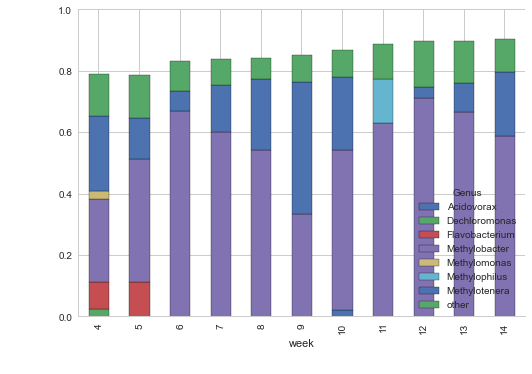

In [59]:
# Demo of simple plot.  Trim rows with abundance some percent.  Plot only one week/oxygen combo. 
def plot_by_abundance(data, abundance):
    d_plot = data[data['abundance'] > abundance]
    d_plot = pd.pivot_table(d_plot, values='abundance', index=['week'], columns='Genus') #.reset_index()
    print d_plot.head()
    d_plot.plot(kind='bar',stacked=True)
    sns.despine()
    #plt.legend(loc=2)
plot_by_abundance(data=data_reduced_genus[
        np.logical_and(
            data_reduced_genus['rep']==1, 
            data_reduced_genus['oxy']=="Low")], abundance=0.02)

In [60]:
# Begin to generalize.  Want to be able to subset by oxygen and replicate. 
def subset_data_by_rep_and_oxy(data, rep, oxy):
    return data[
        np.logical_and(
            data_reduced_genus['rep']==rep, 
            data_reduced_genus['oxy']==oxy)]

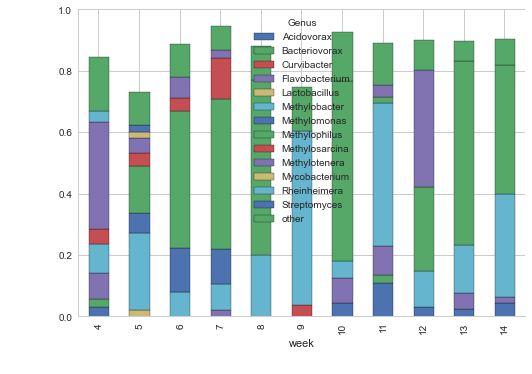

In [61]:
# Make an individual plot with the new subset_data_by_rep_and_oxy() function
def plot_by_abundance(data, abundance):
    d_plot = data[data['abundance'] > abundance]
    d_plot = pd.pivot_table(d_plot, values='abundance', index=['week'], columns='Genus') #.reset_index()
    #print d_plot.head()
    d_plot.plot(kind='bar',stacked=True)
    sns.despine()
    #plt.legend(loc=2)
plot_by_abundance(subset_data_by_rep_and_oxy(data= data_reduced_genus, rep=1, oxy='High'), abundance=0.02)

Figure(640x480)
[[<matplotlib.axes.AxesSubplot object at 0x1128e8450>


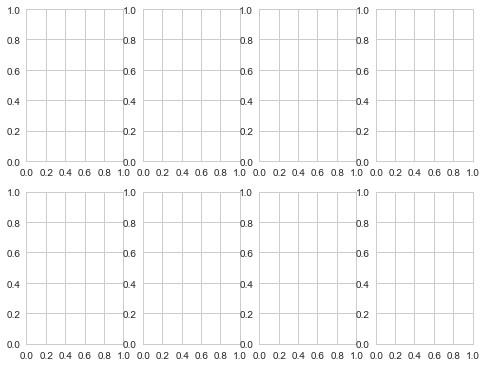

In [62]:
# set up a figure with four subplots. 
fig, axs = plt.subplots(2, 4, figsize=(8, 6))  # ax belongs to fig. 
print fig
print axs

In [63]:
g = data_reduced_genus.groupby(['rep', 'oxy'])
for t, dg in g:
    print t #, dg
    #print t[0]

(1, 'High')
(1, 'Low')
(2, 'High')
(2, 'Low')
(3, 'High')
(3, 'Low')
(4, 'High')
(4, 'Low')


In [64]:
row_dict = {(1, 'High') : 2,
                (1, 'Low')  : 1,
                (2, 'High') : 2,
                (2, 'Low')  : 1,
                (3, 'High') : 2,
                (3, 'Low')  : 1,
                (4, 'High') : 2,
                (4, 'Low')  : 1}

In [65]:
print axs
print ""
axs[(1-1)][2-1]

[[<matplotlib.axes.AxesSubplot object at 0x1128e8450>



In [66]:
#axd = {1:axs[0], 2:axs[1], 3:axs[2], 4:axs[3]}
title_list = ''

for t, df in g:
    #print t
    #print 'plot row:', row_dict[t]
    #print 'plot column:', t[0]
    df.plot(kind='scatter', ax=axs[row_dict[t]-1][t[0]-1], x='week', y='abundance', title='meow')

sns.despine()  # Removes the boxes around the plots.

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


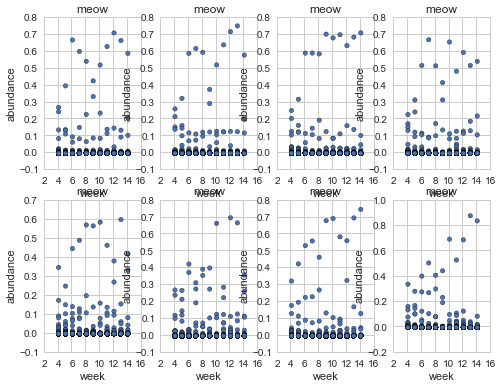

In [67]:
fig

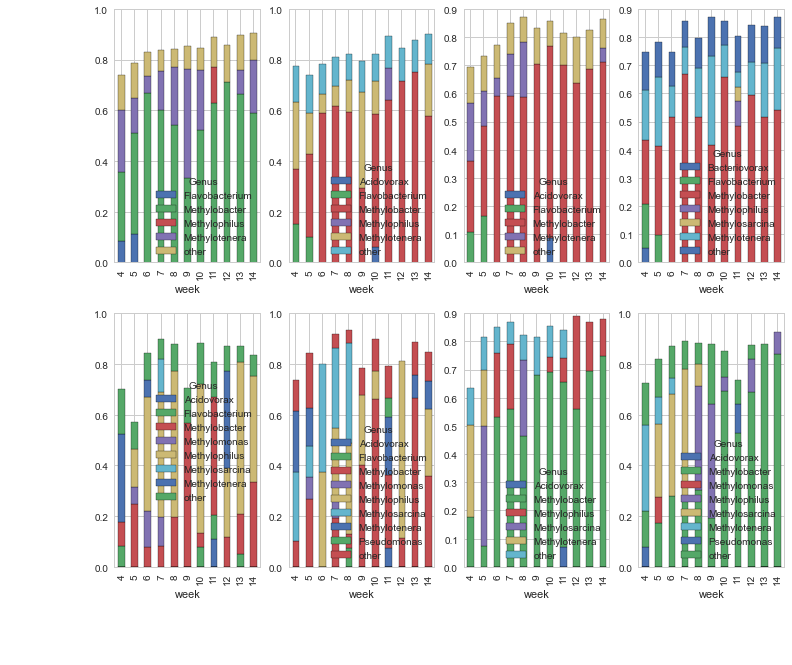

In [68]:
# set up a figure with four subplots. 
fig, axs = plt.subplots(2, 4, figsize=(12, 10))  # ax belongs to fig. 
#print fig
#print axs

# set up groupby 

d_plot = data_reduced_genus[data_reduced_genus['abundance'] > 0.05]
g = d_plot.groupby(['rep', 'oxy'])

#axd = {1:axs[0], 2:axs[1], 3:axs[2], 4:axs[3]}
title_list = ''

row_dict = {(1, 'High') : 2, (2, 'High') : 2, (3, 'High') : 2, (4, 'High') : 2,
            (1, 'Low')  : 1, (2, 'Low')  : 1, (3, 'Low')  : 1, (4, 'Low')  : 1}

for tup, df in g:
    # cast the data
    #print tup # tuple
    data_pivoted = pd.pivot_table(df, values='abundance', 
                                        index=['week'],  # drops all the other columns. 
                                        columns='Genus') 
    #print data_pivoted.head()
    #df.groupby('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'ID', 'oxy', 'rep')
    #print axs[row_dict[tup]-1][tup[0]-1]
    data_pivoted.plot(kind='bar', ax=axs[row_dict[tup]-1][tup[0]-1], stacked=True)  # don't specify x b/c there is only 1 index. 


In [69]:
# fig  # shows the figure.

[[<matplotlib.axes.AxesSubplot object at 0x1123a4c50>


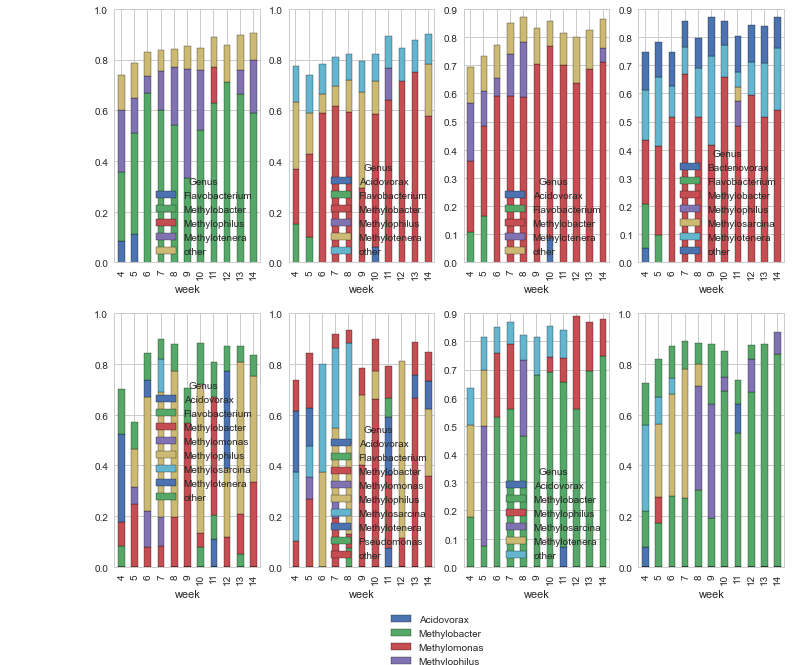

In [70]:
## We can get the last one out, but we want all of them out and want them to have shared colors. 
# set up a figure with four subplots. 
fig, axs = plt.subplots(2, 4, figsize=(12, 10))  # ax belongs to fig. 
#print fig
print axs

# set up groupby 

d_plot = data_reduced_genus[data_reduced_genus['abundance'] > 0.05]
g = d_plot.groupby(['rep', 'oxy'])

#axd = {1:axs[0], 2:axs[1], 3:axs[2], 4:axs[3]}
title_list = ''

row_dict = {(1, 'High') : 2, (2, 'High') : 2, (3, 'High') : 2, (4, 'High') : 2,
            (1, 'Low')  : 1, (2, 'Low')  : 1, (3, 'Low')  : 1, (4, 'Low')  : 1}

for tup, df in g:
    # cast the data
    #print tup # tuple
    data_pivoted = pd.pivot_table(df, values='abundance', 
                                        index=['week'],  # drops all the other columns. 
                                        columns='Genus') 
    #print data_pivoted.head()
    #df.groupby('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'ID', 'oxy', 'rep')
    #print axs[row_dict[tup]-1][tup[0]-1]
    data_pivoted.plot(kind='bar', ax=axs[row_dict[tup]-1][tup[0]-1], stacked=True)  # don't specify x b/c there is only 1 index. 

plt.legend(loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure )            
#legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')   
#fig.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
#         # it will place the legend on the outer right-hand side of the last axes    

In [71]:
import itertools
methods=['method 1', 'method2', 'method 3', 'method 4']
times = range(0, 100, 10)
data = pd.DataFrame(list(itertools.product(methods, times, times)))
data.columns = ['method', 'dtsi','rtsi']
data['nw_score'] = np.random.sample(data.shape[0])
print data.head()

     method  dtsi  rtsi  nw_score
0  method 1     0     0  0.042155
1  method 1     0    10  0.874462
2  method 1     0    20  0.376441
3  method 1     0    30  0.026046
4  method 1     0    40  0.098379


In [72]:
# preview of pivot that happens:  (note use of pivot_table, not pivot.  Aggregating across duplicate rows somehow.)
data.pivot_table(index="dtsi", columns='rtsi', values='nw_score').head()

rtsi,0,10,20,30,40,50,60,70,80,90
dtsi,,,,,,,,,,
0,0.605065,0.868020,0.435364,0.186725,0.345632,0.521935,0.100975,0.780853,0.606804,0.478956
10,0.600225,0.509085,0.689501,0.414386,0.295391,0.544751,0.290178,0.747822,0.596510,0.496840
20,0.668280,0.505485,0.440068,0.555486,0.176638,0.498419,0.374191,0.550991,0.650513,0.614089
30,0.811499,0.341718,0.514215,0.239330,0.686273,0.501902,0.469869,0.535886,0.824954,0.573666
40,0.713260,0.489454,0.554754,0.516808,0.831790,0.502928,0.331169,0.610090,0.297320,0.613974


In [73]:
data['dtsi'].unique()  # x-values
# rtsi are y-values
# cast 

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [74]:
data_reduced_genus.head()

,ID,rep,week,oxy,Genus,index,abundance
7268,118_HOW13,4,13,High,Methylobacter,482,0.880460
11786,130_HOW14,4,14,High,Methylobacter,511,0.840456
45854,82_HOW10,4,10,High,Methylobacter,588,0.696317
2432,106_HOW12,4,12,High,Methylobacter,491,0.690779
26673,40_LOW7,4,7,Low,Methylobacter,655,0.671329


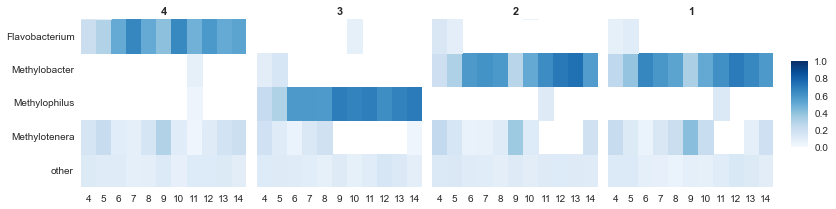

In [75]:
# Make a heat map.  Then we aren't confused by colors, and overwhelmed by the # of labels. 
d_plot = data_reduced_genus[data_reduced_genus['abundance'] > 0.05]

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='Genus', columns='week', values='abundance')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(d_plot[d_plot['oxy']=='Low'], 
                      col="rep", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1)  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot

In [76]:
def filter_by_abundance(data, column, high, low):
    '''Return only rows where genera have one value of abundance in range(low, high)'''
    species_to_keep = data[(data[column] <= high) & (data[column] >= low)]['Genus'].unique()
    print species_to_keep[0:5]# 
    return data[data['Genus'].isin(species_to_keep)]
    #return data[data['Genus'] in species_to_keep]

filter_by_abundance(data=data_reduced_genus, column='abundance', high=1, low=0.5).head()

['Methylobacter' 'Methylosarcina' 'Methylophilus']


,ID,rep,week,oxy,Genus,index,abundance
7268,118_HOW13,4,13,High,Methylobacter,482,0.880460
11786,130_HOW14,4,14,High,Methylobacter,511,0.840456
45854,82_HOW10,4,10,High,Methylobacter,588,0.696317
2432,106_HOW12,4,12,High,Methylobacter,491,0.690779
26673,40_LOW7,4,7,Low,Methylobacter,655,0.671329


['Methylobacter' 'Methylosarcina' 'Methylophilus' 'Methylotenera' 'other']


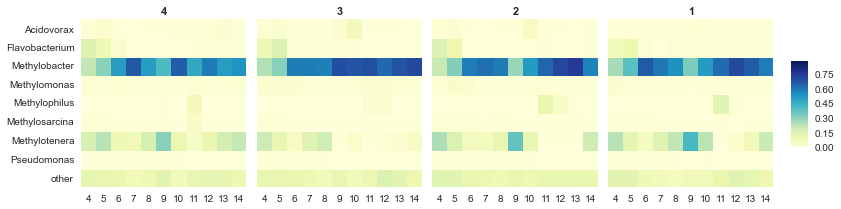

In [77]:
# Make a heat map.  Then we aren't confused by colors, and overwhelmed by the # of labels. 
d_plot = filter_by_abundance(data=data_reduced_genus, column='abundance', high=.8, low=0.1)

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='Genus', columns='week', values='abundance')
    sns.heatmap(data, cmap="YlGnBu", **kws)  # <-- Pass kwargs to heatmap  cmap used to be 'Blue'

with sns.plotting_context(font_scale=7):
    g = sns.FacetGrid(d_plot[d_plot['oxy']=='Low'], 
                      col="rep", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=max(d_plot.abundance))  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot

keep only High oxygen samples
['Methylobacter' 'Methylosarcina' 'Methylophilus']
filename: High_oxygen--0.5_to_0.6_abundance


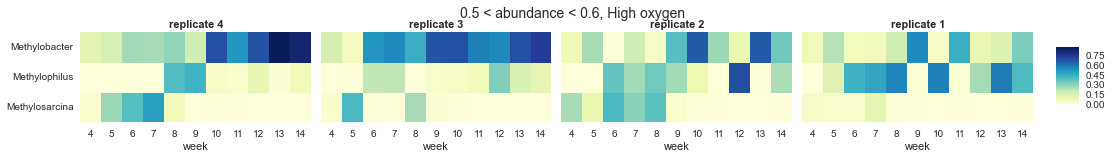

In [128]:
def plot_heatmap(data, high, low, oxy, rep): 
    # get rid of oxygen levels and replicates if specified.
    if oxy is not 'all':
        print "keep only {} oxygen samples".format(oxy)
        data = data[data['oxy']==oxy]
    if rep is not 'all':
        print "keep only replicate levels:", rep
        data = data[data['rep'].isin(rep)]        
    data = filter_by_abundance(data=data, column='abundance', high=high, low=low)
    data['facet_replicate'] = 'replicate ' + data['rep'].astype(str)
    
    # make height of the plot a function of the number of rows (Genera):
    num_data_rows = len(data['Genus'].unique())
    plot_size = 2 +  num_data_rows/7
    plot_aspect = 2
    if num_data_rows > 6:
        plot_aspect = .85
    if num_data_rows > 9:
        plot_aspect = .65
    if num_data_rows > 9:
        plot_aspect = .6
    
    def facet_heatmap(data, color, **kws):
        data = data.pivot(index='Genus', columns='week', values='abundance')
        sns.heatmap(data, cmap="YlGnBu", **kws)  # <-- Pass kwargs to heatmap  cmap used to be 'Blue'
    
    with sns.plotting_context(font_scale=7):
        g = sns.FacetGrid(data, col='facet_replicate', size=plot_size, aspect=plot_aspect)
    
    cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes
    
    g = g.map_dataframe(facet_heatmap,
                        cbar_ax=cbar_ax,
                        vmin=0, vmax=max(data.abundance))  # <-- Specify the colorbar axes and limits
    
    g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
    g.set_axis_labels('week')
    g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
    
    # add a supertitle. 
    plt.subplots_adjust(top=0.80)
    supertitle = str(low) + ' < abundance < ' + str(high) + ', {} oxygen'.format(oxy) 
    g.fig.suptitle(supertitle, size=14)
    
    # write a filename and save.
    plot_dir = './plots/'
    filename = oxy + "_oxygen--{0}_to_{1}_abundance".format(low,high)
    print 'filename:', filename
    g.savefig(plot_dir + filename + '.pdf')

# demo:
plot_heatmap(data=data_reduced_genus, high=0.6, low = 0.5, oxy='High', rep='all')

keep only High oxygen samples
['Methylobacter' 'Methylosarcina' 'Methylophilus' 'Methylotenera' 'other']
filename: High_oxygen--0.1_to_1_abundance


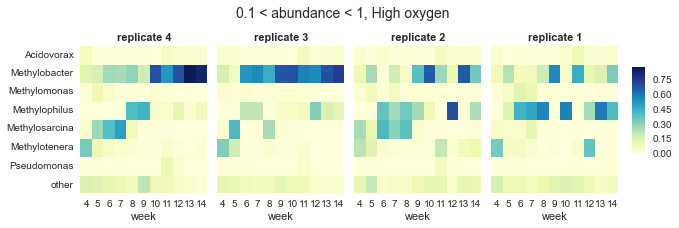

In [121]:
plot_heatmap(data=data_reduced_genus, high=1, low = 0.1, oxy='High', rep='all')

keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Methylophilus']
filename: Low_oxygen--0.02_to_0.5_abundance


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/backends/backend_pdf.py:2036: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


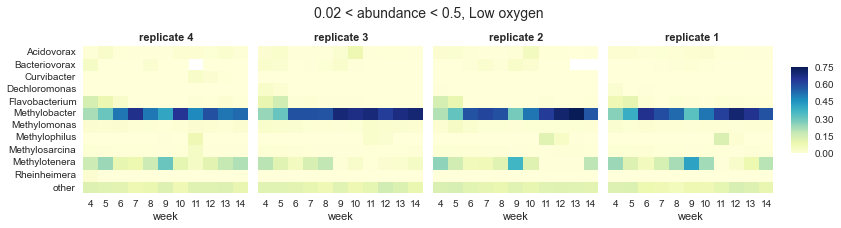

In [83]:
plot_heatmap(data=data_reduced_genus, high=.5, low = 0.02, oxy='Low', rep='all')

keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Methylophilus']
filename: Low_oxygen--0.01_to_1_abundance


KeyboardInterrupt: 

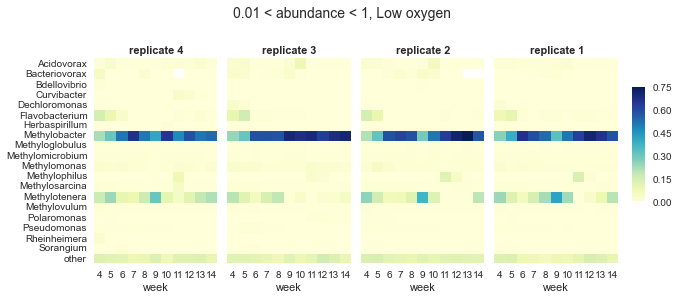

In [129]:
# Loop through the ranges we want. 
oxy_conditions = ['Low', 'High']
range_pairs = [(0.01, 1), (0.05, 1), (0.1, 1), (0.5, 1)]
for o in oxy_conditions:
    for r in range_pairs:
        #print "oxygen:", o
        #print "range:", r
        #print "range (low):", r[0]
        plot_heatmap(data=data_reduced_genus, low =r[0], high=r[1], oxy=o, rep='all')

keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Methylophilus']
filename: Low_oxygen--0.01_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Methylophilus']
filename: Low_oxygen--0.05_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter' 'Methylotenera' 'Flavobacterium' 'other' 'Methylophilus']
filename: Low_oxygen--0.1_to_0.6_abundance
keep only Low oxygen samples
['Methylobacter']
filename: Low_oxygen--0.5_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylosarcina' 'Methylophilus' 'Methylotenera' 'other']
filename: High_oxygen--0.01_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylosarcina' 'Methylophilus' 'Methylotenera' 'other']
filename: High_oxygen--0.05_to_0.6_abundance
keep only High oxygen samples
['Methylobacter' 'Methylosarcina' 'Methylophilus' 'Methylotenera' 'other']
filename: High_oxygen--0.1_to_0.6_abundance
keep only High oxy

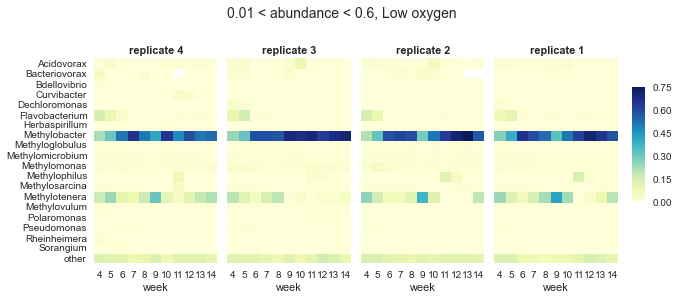

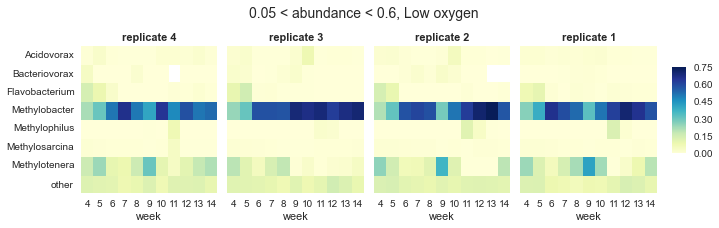

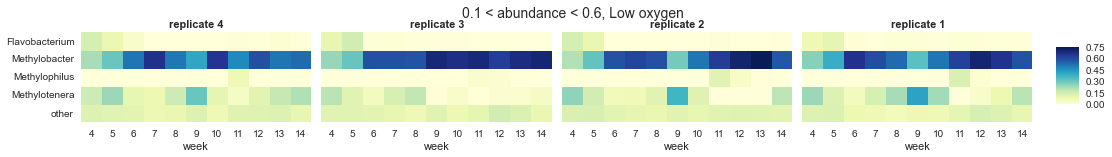

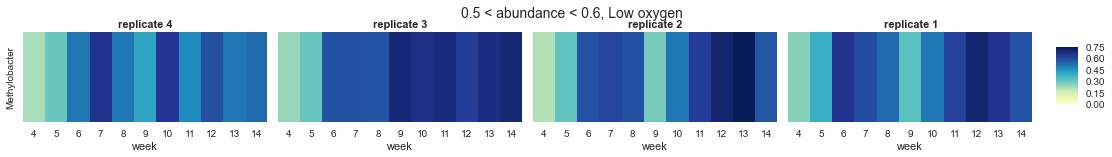

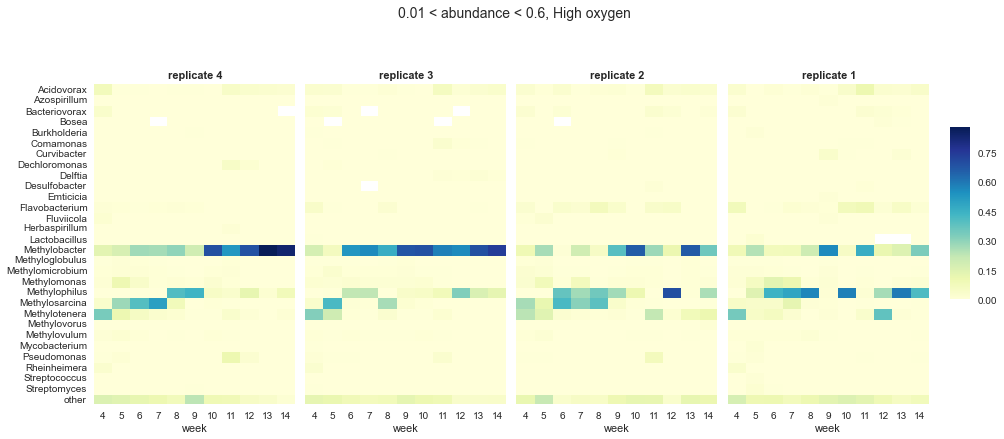

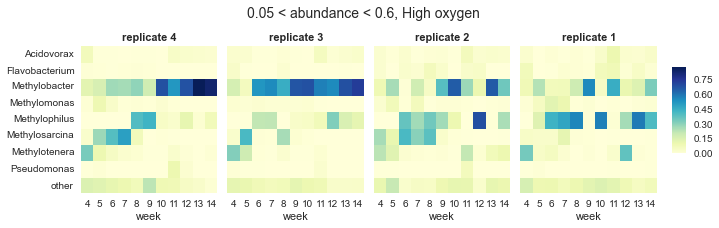

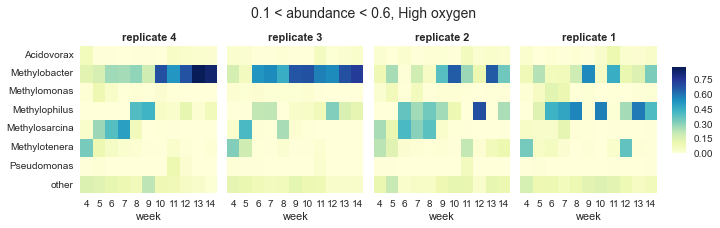

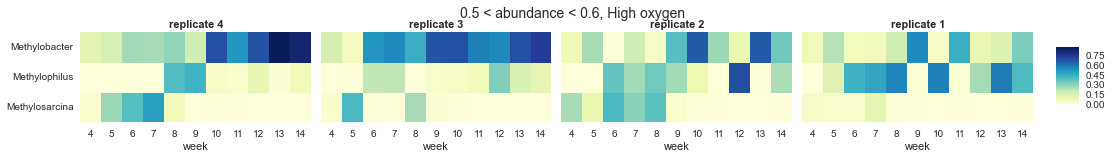

In [131]:
# Loop through the ranges we want. 
oxy_conditions = ['Low', 'High']
max_abundance = 0.6
range_pairs = [(0.01, max_abundance), (0.05, max_abundance), (0.1, max_abundance), (0.5, max_abundance)]
for o in oxy_conditions:
    for r in range_pairs:
        #print "oxygen:", o
        #print "range:", r
        #print "range (low):", r[0]
        plot_heatmap(data=data_reduced_genus, low =r[0], high=r[1], oxy=o, rep='all')